In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
from time import sleep
import time

import os
import sys
import h5py
import numpy as np
import pandas as pd
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import glob

import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
def reduce_spatial(img, scale):
    width = int(img.shape[1] * scale / 100)
    height = int(img.shape[0] * scale / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized

def scaleArea(orig_frame, targetArea=(512*288)):
  frameArea = orig_frame.shape[0]*orig_frame.shape[1]
  s = np.sqrt(targetArea/frameArea)
  dim = (int(orig_frame.shape[1]*s),int(orig_frame.shape[0]*s))
  resized = cv2.resize(orig_frame, dim, interpolation = cv2.INTER_AREA)
  return resized, s


def load_frames(data_path, video_name, reduce=False):
  frames = []
  for i in sorted(glob.glob(data_path + '/' + video_name +'/*.png')):
    img = cv2.imread(i, 0)
    if reduce:
      # img = reduce_spatial(img, 30)
      img, _ = scaleArea(img)
    frames.append(img)
  frames = np.array(frames)
  return frames  


def load_video(data_path, video_name, reduce=False):
  gif = cv2.VideoCapture(data_path + video_name)
  num_frames = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
  frames = []
  for i in range(num_frames):
    ret, frame = gif.read()
    if ret:
      frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      img = frame_gray
      # resize image
      if reduce:
        # img = reduce_spatial(img, 30)
        img, _ = scaleArea(img)
      frames.append(img)
    else:
      break
  return np.array(frames)


def calculateOF(frames, data_path, video_name, reduce=False, sub_mean=False, store=False, save_folder='opticalFlow'):
  t1 = time.time()
  height, width = frames.shape[1], frames.shape[2]
  u_list = np.zeros((frames.shape[0], height, width))
  v_list = np.zeros((frames.shape[0], height, width))

  # calculate OF with opencv
  for ff in range(1, frames.shape[0]):
    prvs = frames[ff-1] # - frames[ff-1].mean()
    next = frames[ff] # -  frames[ff].mean()
    if sub_mean:
      prvs = prvs - prvs.mean()
      next = next - next.mean()
    # add filtering
    # prvs = gaussian_filter(prvs, 1.5)
    # next = gaussian_filter(next, 1.5)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 25, 3, 5, 1.2, 0) # window 15
    u_list[ff, :, :] = flow[:,:,0]
    v_list[ff, :, :] = flow[:,:,1]
  print('Time to compute OF:', time.time() - t1)
  # save 
  if store:
    save_path = os.path.join(data_path, folder)
    os.makedirs(save_path, exist_ok=True)
    hf = h5py.File(save_path + '/' + video_name + '.h5', 'w')
    hf.create_dataset('u', data=u_list)
    hf.create_dataset('v', data=v_list)
    hf.close()

  return u_list, v_list


In [4]:
def get_signals(u, v):
  mag = u ** 2 + v ** 2
  orient  = np.arctan2(v, u) * 180/np.pi
  orient[orient < 0] += 360
  bins = []
  means = []
  max_deviations = 1
  for i in range(1, u.shape[0]):
    # filter magnitude using stats of each frame
    thrsh = max_deviations * mag[i].std()
    upper = mag[i].mean() + mag[i].std()
    # thrsh = 0.3
    pos = np.where(mag[i] < thrsh)
    mag[i, pos[0], pos[1]] = 0

    filt_mag = mag[i][mag[i] >= thrsh]
    # filt_mag = mag[i][np.logical_and(mag[i]>thrsh, mag[i]<upper)]
    # append the mean magnitude above thrsh
    means.append(filt_mag.mean())

    hh, bb = np.histogram(orient[i].ravel(), bins=10, weights=mag[i].ravel(), density=True)
    bins.append(hh.argmax())

  return mag, orient, means, bins


def get_prediction(means, gt, name, window, scale=1):
  mm = np.array(means)
  # depends on number of frames
  # calculate approximate derivative
  g = np.convolve(mm, np.ones(window)/window, 'same')
  der = np.diff(g)

  # upper = der.mean() + scale*der.std()
  # lower = der.mean() - scale*der.std()
  # der = der[np.logical_and(der>lower, der<upper)]
  thrsh = der.mean() + 1 * der.std() # std is too large

  # thrsh = np.percentile(der, 75) # this works better for urfd videos

  print(thrsh)
  try:
    pred_on = np.where(der > thrsh)[0][0] + 1
    # pred = np.argmax(der) + 1 
  except:
    pred_on = 0

  return pred_on, der

In [5]:
# for our database
main = '/content/drive/My Drive/Colab Notebooks/CV_notebooks/project/'
data_dir = '/content/drive/My Drive/our_fall_dataset/'

names = os.listdir(data_dir)

ann = pd.read_csv(main + 'our_dataset_master.csv')

name = 'erica-11.mp4'
print('Processing video ', name)
frames = load_video(data_dir, name, reduce=True)
u, v = calculateOF(frames, main, name, sub_mean=True)
mag, orient, means, bins = get_signals(u, v)

sub = ann[ann['sequence_name']==name[:-4]]
if sub['fall_label'].values[0]:
  gt = sub['fall_start_frame'].values[0]
  te = sub['fall_end_frame'].values[0]
else:
  gt = 0
  te = 0
window = len(means) * 0.05
prediction_on, der = get_prediction(means, gt, name, int(window), 3)
print('Annotated fall onset:', gt)
print('Predicted fall onset:', prediction_on)

Processing video  erica-11.mp4
Time to compute OF: 9.481508255004883
6.824966624093528
Annotated fall onset: 115.0
Predicted fall onset: 86


Text(0.5, 1.0, 'Approximate derivative')

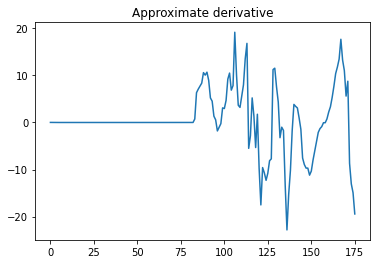

In [6]:
plt.plot(der)
plt.title('Approximate derivative')

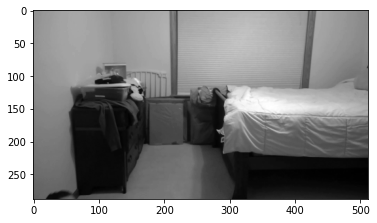

In [8]:
def visualize_video(vv):
  for i in range(vv.shape[0]):
    clear_output(wait=True)

    # Display the image here
    plt.imshow(vv[i], cmap='gray')
    
    plt.show()
    sleep(0.2)

visualize_video(frames)

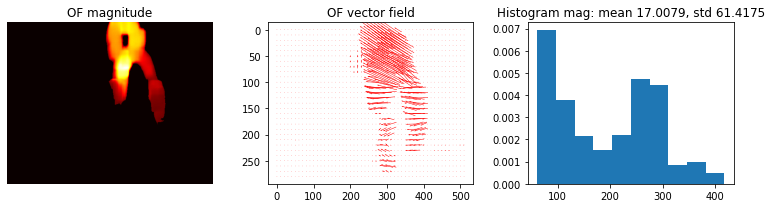

In [9]:
def visualize(mag, u, v, frame=None):
  if frame is not None:
    ids = [frame]
  else:
    ids = list(range(u.shape[0]))
  for ff in ids:
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))
    width = u.shape[2]
    height = u.shape[1]
    x = np.arange(0, width, 1)
    y = np.arange(0, height, 1)
    x, y = np.meshgrid(x, y)
    step = 10
    ax1.imshow(mag[ff], cmap='hot', aspect='auto')
    ax1.set_title('OF magnitude')
    ax1.axis('off')
    # plt.subplot(132)
    ax2.quiver(x[::step, ::step], y[::step, ::step],
              u[ff][::step, ::step], v[ff][::step, ::step],
              color='r', pivot='middle', headwidth=2, headlength=3)
    ax2.invert_yaxis()
    ax2.set_title('OF vector field')
    # plt.subplot(133)
    max_deviations = 1
    thrsh = max_deviations * mag[ff].std()
    filt_mag = mag[ff][mag[ff]>=thrsh]
    means.append(filt_mag.mean())
    ax3.hist(filt_mag.ravel(), bins=10, density=True)
    title = 'Histogram mag: mean {}, std {}'.format(np.round(mag[ff].mean(), 4), np.round(mag[ff].std(), 4))
    ax3.set_title(title)
    fig.tight_layout()

    plt.show()
    sleep(0.3)

visualize(mag, u, v, frame=int(gt))

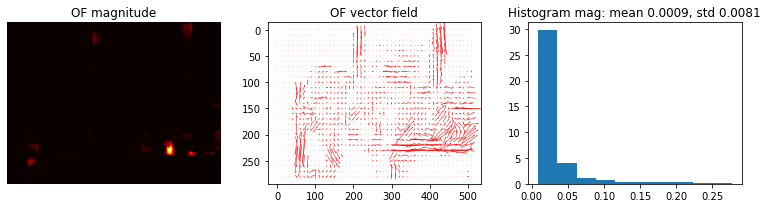

In [10]:
visualize(mag, u, v, frame=int(prediction_on))